In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

Didikoglu, Altug; Lucas, Robert J; Brown, Timothy M (2023). Data: Associations between light exposure and sleep timing and sleepiness while awake in a sample of UK adults in everyday life. University of Manchester. Dataset. https://doi.org/10.48420/23786238.v1

In [78]:
baseline = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_baseline.csv")
kss = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_kss.csv")
light = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_light_exposure.csv")
sleep = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_sleep.csv")

In [3]:
baseline.head()

,id,age,sex,caffeineGeneralUnit,smokeGeneralUnit,alcoholGeneralFreq,healthSubjRate,chronotypeSubjRate,PSQItotalScore,MCTQmsfsc,IPAQactivityCategory
0,1,26-30,Male,4.0,Never,Special occasions,very good,Rather more an evening type than a morning type,3,6.303571,Moderate
1,2,26-30,Female,4.0,Never,Special occasions,very good,Definitely a morning type,7,4.750000,Moderate
2,3,51-55,Male,4.0,Never,1-2 in a week,very good,Rather more a morning type than an evening type,4,3.166667,Moderate
3,4,31-35,Male,3.0,Never,Never,good,Rather more a morning type than an evening type,4,4.482143,Moderate
4,5,36-40,Female,3.0,Never,3-4 in a week,very good,Definitely an evening type,4,5.660714,High


In [4]:
baseline.shape

(59, 11)

In [5]:
baseline.isnull().sum()

id                      0
age                     0
sex                     0
caffeineGeneralUnit     1
smokeGeneralUnit        0
alcoholGeneralFreq      0
healthSubjRate          0
chronotypeSubjRate      0
PSQItotalScore          0
MCTQmsfsc               0
IPAQactivityCategory    0
dtype: int64

In [6]:
kss.head()

,id,datatime,timeofday,timeawake,kss
0,1,2022-02-21 12:43:15,12.717,5.217,3
1,1,2022-02-21 12:45:30,12.750,5.250,3
2,1,2022-02-21 14:08:10,14.133,6.633,4
3,1,2022-02-21 15:19:15,15.317,7.817,5
4,1,2022-02-21 17:06:15,17.100,9.600,6


In [7]:
kss.shape

(1799, 5)

In [8]:
kss.isnull().sum()

id            0
datatime      0
timeofday     0
timeawake    18
kss           0
dtype: int64

In [9]:
light.head()

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux
0,1,2022-02-21 12:33:00,259.933986,369.341318,357.840096,505.974584,551.385621,562.721928
1,1,2022-02-21 12:33:30,48.984336,74.719314,73.987286,110.303445,119.310881,120.018312
2,1,2022-02-21 12:34:00,148.126443,159.488825,109.944697,115.173327,94.927285,132.861370
3,1,2022-02-21 12:34:30,23.922818,167.329340,280.754992,488.708210,616.006479,532.385790
4,1,2022-02-21 12:35:00,360.207330,493.142531,455.501441,625.170105,668.800388,701.371976


In [10]:
light.shape

(1206093, 8)

In [11]:
light.isnull().sum()

id              0
datatime        0
SconeopicEDI    0
MelanopicEDI    0
RodopicEDI      0
MconeopicEDI    0
LconeopicEDI    0
PhotopicLux     0
dtype: int64

In [12]:
sleep.head()

,id,datatime,timeofday,timeawake,kss
0,1,2022-02-21 12:43:15,12.717,5.217,3
1,1,2022-02-21 12:45:30,12.750,5.250,3
2,1,2022-02-21 14:08:10,14.133,6.633,4
3,1,2022-02-21 15:19:15,15.317,7.817,5
4,1,2022-02-21 17:06:15,17.100,9.600,6


In [13]:
sleep.shape

(1799, 5)

In [14]:
sleep.isnull().sum()

id            0
datatime      0
timeofday     0
timeawake    18
kss           0
dtype: int64

In [15]:
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206093 entries, 0 to 1206092
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            1206093 non-null  int64  
 1   datatime      1206093 non-null  object 
 2   SconeopicEDI  1206093 non-null  float64
 3   MelanopicEDI  1206093 non-null  float64
 4   RodopicEDI    1206093 non-null  float64
 5   MconeopicEDI  1206093 non-null  float64
 6   LconeopicEDI  1206093 non-null  float64
 7   PhotopicLux   1206093 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 73.6+ MB


In [16]:
light['datatime'] = pd.to_datetime(light['datatime'], errors='coerce')

In [17]:
print(light['datatime'].isna().sum())

15


In [18]:
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206093 entries, 0 to 1206092
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            1206093 non-null  int64         
 1   datatime      1206078 non-null  datetime64[ns]
 2   SconeopicEDI  1206093 non-null  float64       
 3   MelanopicEDI  1206093 non-null  float64       
 4   RodopicEDI    1206093 non-null  float64       
 5   MconeopicEDI  1206093 non-null  float64       
 6   LconeopicEDI  1206093 non-null  float64       
 7   PhotopicLux   1206093 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 73.6 MB


In [19]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux
0,1,2022-02-21 12:33:00,259.933986,369.341318,357.840096,505.974584,551.385621,562.721928
1,1,2022-02-21 12:33:30,48.984336,74.719314,73.987286,110.303445,119.310881,120.018312


convert light_exposure dataset time to timeofday, like in kss dataset timeofday

In [20]:
def add_time_of_day_column(df, datetime_column):
    # Make sure the column is in datetime format
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    
    # Function to convert time to decimal hours
    def time_to_decimal(t):
        return round(t.hour + t.minute / 60 + t.second / 3600, 3)

    # Apply the conversion
    df['timeofday'] = df[datetime_column].dt.time.apply(time_to_decimal)
    
    return df

In [21]:
light = add_time_of_day_column(light, 'datatime')

remove PhotopicLux values for match indoor/daylight lighting.
100 > PhotopicLux means dim room and PhotopicLux > 20000 means xtreme sunlight

In [22]:
light = light[light['PhotopicLux'] > 50]
light = light[light['PhotopicLux'] < 20000]

In [23]:
# Apply rolling average (e.g., 5-sample window)
light['PhotopicLux'] = light['PhotopicLux'].rolling(window=60, center=True).mean()
light['MelanopicEDI'] = light['MelanopicEDI'].rolling(window=60, center=True).mean()

make melanopic_ratio inside useful biological range ( 0.3 - 1.2 )

In [24]:
light['mel_ratio'] = light['MelanopicEDI'] / light['PhotopicLux']
light['mel_ratio'] = light['mel_ratio'].clip(lower=0.3, upper=1.2)

In [25]:
mel_min = light['mel_ratio'].min()
mel_max = light['mel_ratio'].max()

print(f"Minimum melanopic_ratio: {mel_min:.3f}")
print(f"Maximum melanopic_ratio: {mel_max:.3f}")

Minimum melanopic_ratio: 0.300
Maximum melanopic_ratio: 1.200


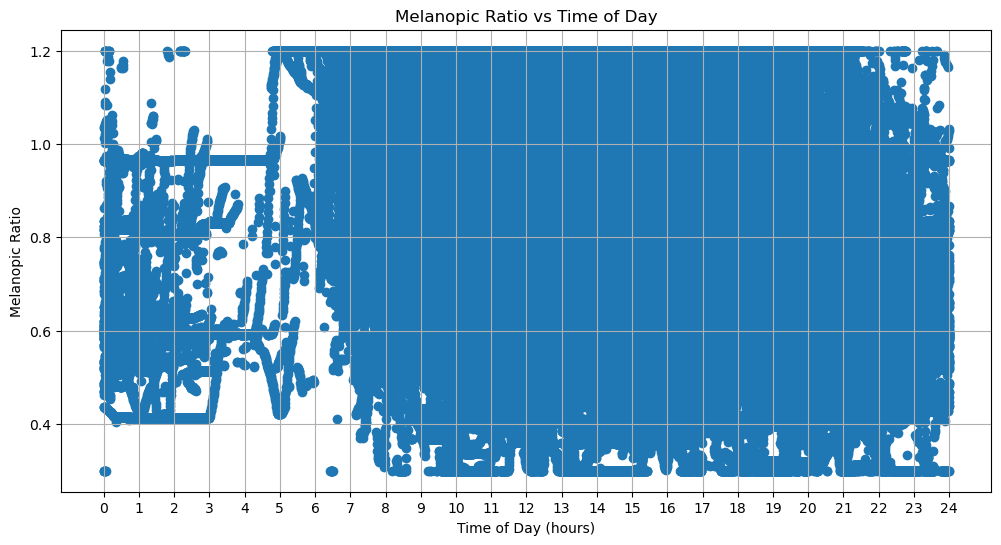

In [26]:
plt.figure(figsize=(12, 6))
plt.scatter(light['timeofday'], light['mel_ratio'])
plt.title('Melanopic Ratio vs Time of Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Melanopic Ratio')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

calculate CCT values according to standard LED CCT values and typical melanopic ratio <br>
https://luminusdevices.zendesk.com/hc/en-us/articles/4409868024461-What-is-the-Melanopic-Ratio <br>
<img src="mceclip2.png" alt="CCT-MR" width="300">

In [27]:
# Estimate CCT from ratio

# Known points from your uploaded chart
melanopic_ratios = np.array([0.399, 0.442, 0.525, 0.631, 0.668, 0.836, 0.976])
cct_values = np.array([2400, 2700, 3000, 3500, 4000, 5000, 6500])

# Build interpolation function
mel_ratio_to_cct = interp1d(melanopic_ratios, cct_values, kind='linear', fill_value='extrapolate')

In [28]:
light['CCT_estimated'] = mel_ratio_to_cct(light['mel_ratio'])

In [29]:
light.head(30)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
0,1,2022-02-21 12:33:00,259.933986,NaN,357.840096,505.974584,551.385621,NaN,12.550,NaN,NaN
1,1,2022-02-21 12:33:30,48.984336,NaN,73.987286,110.303445,119.310881,NaN,12.558,NaN,NaN
2,1,2022-02-21 12:34:00,148.126443,NaN,109.944697,115.173327,94.927285,NaN,12.567,NaN,NaN
3,1,2022-02-21 12:34:30,23.922818,NaN,280.754992,488.708210,616.006479,NaN,12.575,NaN,NaN
4,1,2022-02-21 12:35:00,360.207330,NaN,455.501441,625.170105,668.800388,NaN,12.583,NaN,NaN
5,1,2022-02-21 12:35:30,156.518838,NaN,234.407020,335.533416,372.904136,NaN,12.592,NaN,NaN
6,1,2022-02-21 12:36:00,260.760111,NaN,362.008904,509.618044,556.406727,NaN,12.600,NaN,NaN
7,1,2022-02-21 12:36:30,266.924541,NaN,369.679140,518.414103,566.464906,NaN,12.608,NaN,NaN
8,1,2022-02-21 12:37:00,257.265708,NaN,355.549670,499.321044,545.654742,NaN,12.617,NaN,NaN
9,1,2022-02-21 12:37:30,266.577598,NaN,367.746170,516.113384,563.584722,NaN,12.625,NaN,NaN


In [30]:
light = light.dropna(subset=['PhotopicLux', 'mel_ratio'])

In [31]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
30,1,2022-02-21 12:48:00,335.738506,394.002590,467.291259,655.976705,719.501618,600.061117,12.800,0.656604,3846.001371
31,1,2022-02-21 12:48:30,344.826246,403.771883,482.031753,677.706891,742.561614,605.262581,12.808,0.667102,3987.864982


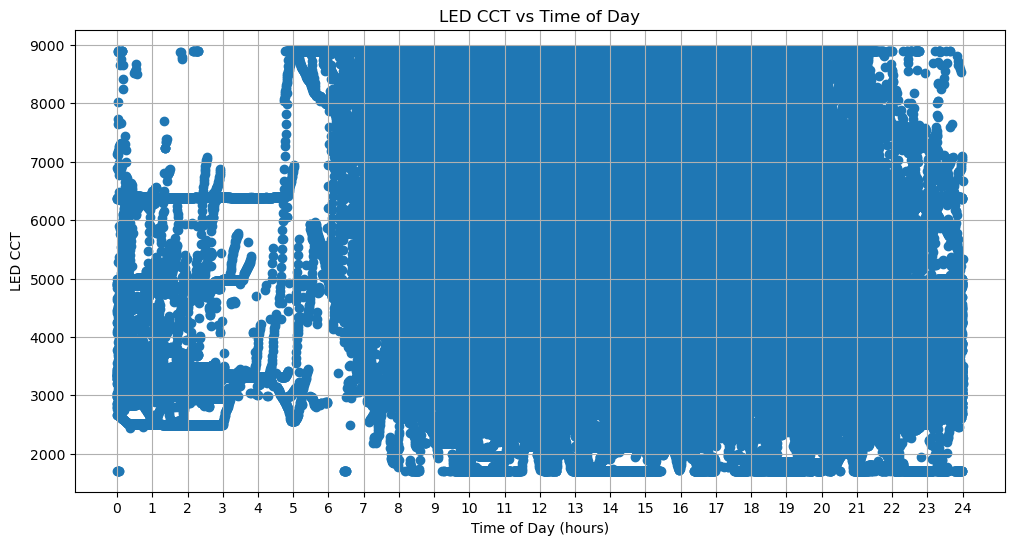

In [32]:
plt.figure(figsize=(12, 6))
plt.scatter(light['timeofday'], light['CCT_estimated'])
plt.title('LED CCT vs Time of Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('LED CCT')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [33]:
print(light['PhotopicLux'])

30          600.061117
31          605.262581
32          627.501405
33          642.306859
34          647.051599
              ...     
1206045    2340.123046
1206046    2353.344313
1206047    2365.449154
1206048    2524.312145
1206049    2687.059566
Name: PhotopicLux, Length: 413156, dtype: float64


In [34]:
print(light['PhotopicLux'].describe())

count    413156.000000
mean       1050.621327
std        1648.803225
min          50.243824
25%         174.588355
50%         393.747536
75%        1103.181251
max       19383.694558
Name: PhotopicLux, dtype: float64


In [35]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
30,1,2022-02-21 12:48:00,335.738506,394.002590,467.291259,655.976705,719.501618,600.061117,12.800,0.656604,3846.001371
31,1,2022-02-21 12:48:30,344.826246,403.771883,482.031753,677.706891,742.561614,605.262581,12.808,0.667102,3987.864982


In [36]:
kss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1799 non-null   int64  
 1   datatime   1799 non-null   object 
 2   timeofday  1799 non-null   float64
 3   timeawake  1781 non-null   float64
 4   kss        1799 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 70.4+ KB


In [37]:
kss['datatime'] = pd.to_datetime(kss['datatime'], errors='coerce')

In [38]:
kss.info()
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         1799 non-null   int64         
 1   datatime   1799 non-null   datetime64[ns]
 2   timeofday  1799 non-null   float64       
 3   timeawake  1781 non-null   float64       
 4   kss        1799 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 70.4 KB
<class 'pandas.core.frame.DataFrame'>
Index: 413156 entries, 30 to 1206049
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             413156 non-null  int64         
 1   datatime       413155 non-null  datetime64[ns]
 2   SconeopicEDI   413156 non-null  float64       
 3   MelanopicEDI   413156 non-null  float64       
 4   RodopicEDI     413156 non-null  float64       
 5   MconeopicEDI   413

In [39]:
kss.head()

,id,datatime,timeofday,timeawake,kss
0,1,2022-02-21 12:43:15,12.717,5.217,3
1,1,2022-02-21 12:45:30,12.750,5.250,3
2,1,2022-02-21 14:08:10,14.133,6.633,4
3,1,2022-02-21 15:19:15,15.317,7.817,5
4,1,2022-02-21 17:06:15,17.100,9.600,6


In [40]:
# Merge on ID
merged = light.merge(kss, on='id', suffixes=('_exp', '_kss'))

# Keep only rows where KSS is within 30 minutes AFTER exposure
merged = merged[
    (merged['datatime_kss'] >= merged['datatime_exp']) &
    (merged['datatime_kss'] <= merged['datatime_exp'] + pd.Timedelta(minutes=30))
]

# Add a column for time difference
merged['time_diff'] = (merged['datatime_kss'] - merged['datatime_exp']).abs()

# Keep only the nearest KSS per exposure
filtered = merged.sort_values(by='time_diff').groupby(['id', 'datatime_exp']).first().reset_index()

In [41]:
filtered

,id,datatime_exp,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday_exp,mel_ratio,CCT_estimated,datatime_kss,timeofday_kss,timeawake,kss,time_diff
0,1,2022-02-21 13:38:30,344.859786,530.597498,422.738084,570.215641,603.395769,750.743974,13.642,0.706762,4230.727663,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:29:40
1,1,2022-02-21 13:39:00,353.819181,517.799574,494.280637,691.446072,758.734620,741.885946,13.650,0.697950,4178.276042,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:29:10
2,1,2022-02-21 13:39:30,360.318543,500.174115,503.184610,704.639551,772.404470,727.843792,13.658,0.687200,4114.284576,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:28:40
3,1,2022-02-21 13:40:00,360.460979,493.054753,503.461820,706.557523,774.306754,723.443052,13.667,0.681539,4080.590099,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:28:10
4,1,2022-02-21 13:40:30,360.100114,482.561200,502.535329,704.943483,772.830461,714.664590,13.675,0.675228,4043.020967,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:27:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42586,59,2022-06-30 10:54:57,76.161964,95.738756,133.181116,110.930422,112.090750,102.727002,10.916,0.931973,6028.278355,2022-06-30 10:56:58,10.942,1.692,4,0 days 00:02:01
42587,59,2022-06-30 10:55:27,71.462525,96.547683,124.668014,103.988856,104.982251,103.587105,10.924,0.932043,6029.037030,2022-06-30 10:56:58,10.942,1.692,4,0 days 00:01:31
42588,59,2022-06-30 10:55:57,69.748097,96.029266,121.617204,101.634836,102.627789,102.996553,10.932,0.932354,6032.366100,2022-06-30 10:56:58,10.942,1.692,4,0 days 00:01:01
42589,59,2022-06-30 10:56:27,69.024726,96.573049,120.888039,100.909189,102.013878,103.560306,10.941,0.932530,6034.245517,2022-06-30 10:56:58,10.942,1.692,4,0 days 00:00:31


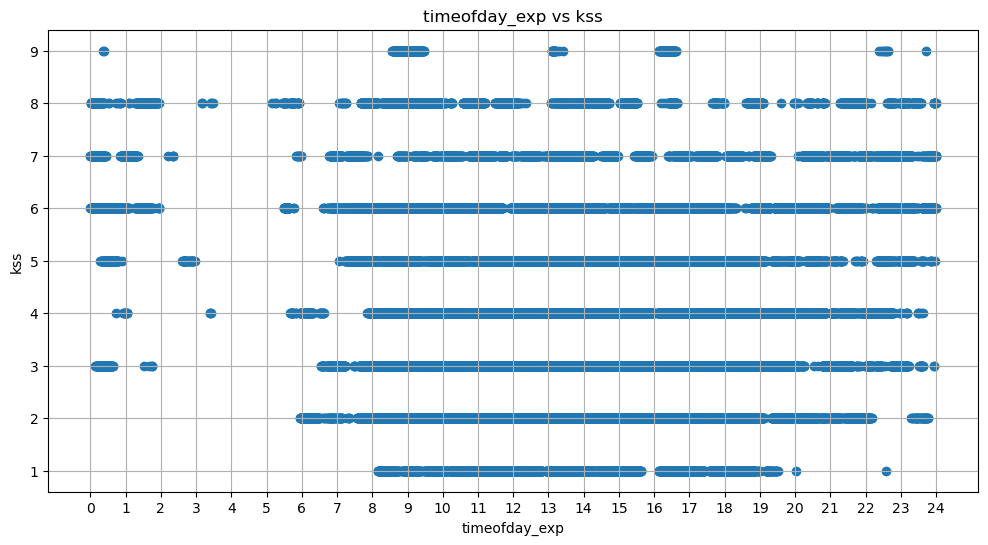

In [42]:
plt.figure(figsize=(12, 6))
plt.scatter(filtered['timeofday_exp'], filtered['kss'])
plt.title('timeofday_exp vs kss')
plt.xlabel('timeofday_exp')
plt.ylabel('kss')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [43]:
dupes_light = light.duplicated(subset=['id', 'datatime']).sum()
dupes_kss = kss.duplicated(subset=['id', 'datatime']).sum()
print("Duplicates in light:", dupes_light)
print("Duplicates in kss:", dupes_kss)

Duplicates in light: 0
Duplicates in kss: 0


In [44]:
filtered.isnull().sum()

id                 0
datatime_exp       0
SconeopicEDI       0
MelanopicEDI       0
RodopicEDI         0
MconeopicEDI       0
LconeopicEDI       0
PhotopicLux        0
timeofday_exp      0
mel_ratio          0
CCT_estimated      0
datatime_kss       0
timeofday_kss      0
timeawake        296
kss                0
time_diff          0
dtype: int64

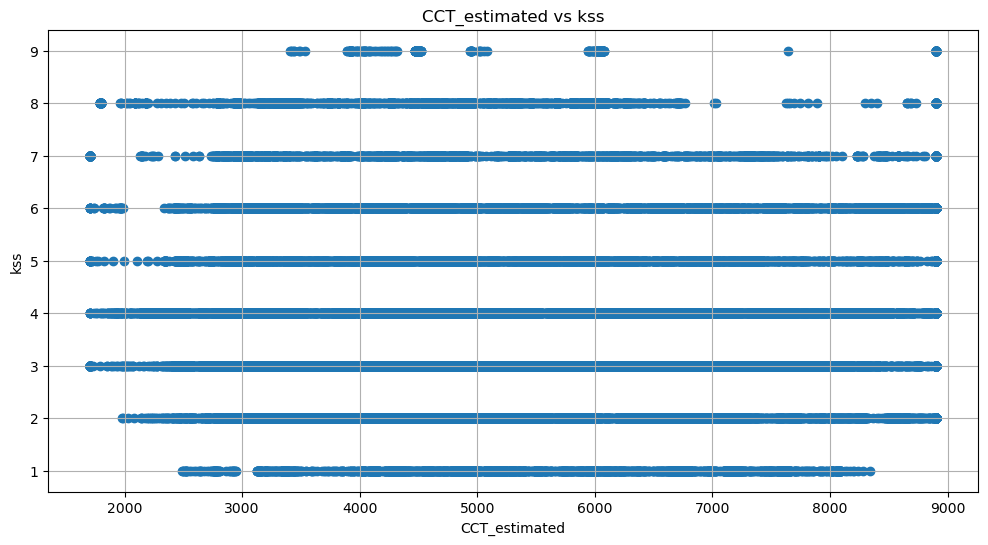

In [45]:
plt.figure(figsize=(12, 6))
plt.scatter(filtered['CCT_estimated'], filtered['kss'])
plt.title('CCT_estimated vs kss')
plt.xlabel('CCT_estimated')
plt.ylabel('kss')
plt.grid(True)
plt.show()

In [46]:
def get_day_phase(hour):
    if 6 <= hour < 18:
        return 'day'
    else:
        return 'night'

filtered['hour'] = filtered['datatime_exp'].dt.hour
filtered['day_phase'] = filtered['hour'].apply(get_day_phase)

In [47]:
filtered.head(2)

,id,datatime_exp,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday_exp,mel_ratio,CCT_estimated,datatime_kss,timeofday_kss,timeawake,kss,time_diff,hour,day_phase
0,1,2022-02-21 13:38:30,344.859786,530.597498,422.738084,570.215641,603.395769,750.743974,13.642,0.706762,4230.727663,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:29:40,13,day
1,1,2022-02-21 13:39:00,353.819181,517.799574,494.280637,691.446072,758.734620,741.885946,13.650,0.697950,4178.276042,2022-02-21 14:08:10,14.133,6.633,4,0 days 00:29:10,13,day


In [48]:
# For daytime samples, keep alert (low KSS)
day_samples = filtered[(filtered['day_phase'] == 'day') & (filtered['kss'] <= 5)]

# For nighttime samples, keep sleepy (high KSS)
night_samples = filtered[(filtered['day_phase'] == 'night') & (filtered['kss'] >= 6)]

# Combine
good_circadian = pd.concat([day_samples, night_samples])

In [49]:
good_circadian

,id,datatime_exp,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday_exp,mel_ratio,CCT_estimated,datatime_kss,timeofday_kss,timeawake,kss,time_diff,hour,day_phase
0,1,2022-02-21 13:38:30,344.859786,530.597498,422.738084,570.215641,603.395769,750.743974,13.642,0.706762,4230.727663,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:29:40,13,day
1,1,2022-02-21 13:39:00,353.819181,517.799574,494.280637,691.446072,758.734620,741.885946,13.650,0.697950,4178.276042,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:29:10,13,day
2,1,2022-02-21 13:39:30,360.318543,500.174115,503.184610,704.639551,772.404470,727.843792,13.658,0.687200,4114.284576,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:28:40,13,day
3,1,2022-02-21 13:40:00,360.460979,493.054753,503.461820,706.557523,774.306754,723.443052,13.667,0.681539,4080.590099,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:28:10,13,day
4,1,2022-02-21 13:40:30,360.100114,482.561200,502.535329,704.943483,772.830461,714.664590,13.675,0.675228,4043.020967,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:27:40,13,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42464,59,2022-06-29 00:20:57,24.170873,78.012152,81.253181,52.313170,52.922300,113.943855,0.349,0.684654,4099.132830,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:23:46,0,night
42465,59,2022-06-29 00:29:57,23.432972,78.530065,75.580988,50.955985,47.683533,114.023176,0.499,0.688720,4123.334570,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:14:46,0,night
42466,59,2022-06-29 00:30:57,14.410925,79.026117,37.146394,36.633560,20.748596,114.060311,0.516,0.692845,4147.886948,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:13:46,0,night
42467,59,2022-06-29 00:43:27,21.205208,76.808501,65.708868,55.598958,55.162881,109.503683,0.724,0.701424,4198.951816,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:01:16,0,night


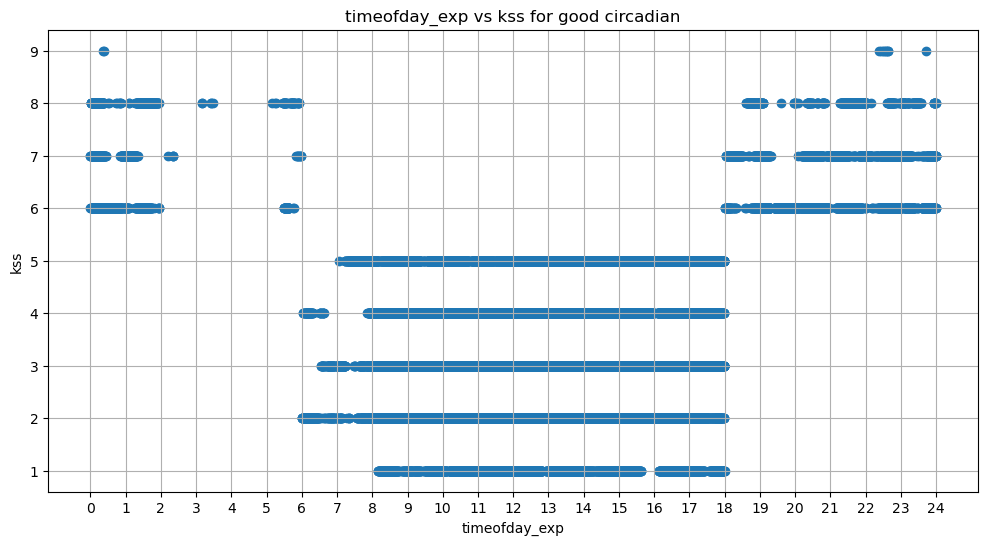

In [50]:
plt.figure(figsize=(12, 6))
plt.scatter(good_circadian['timeofday_exp'], good_circadian['kss'])
plt.title('timeofday_exp vs kss for good circadian')
plt.xlabel('timeofday_exp')
plt.ylabel('kss')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

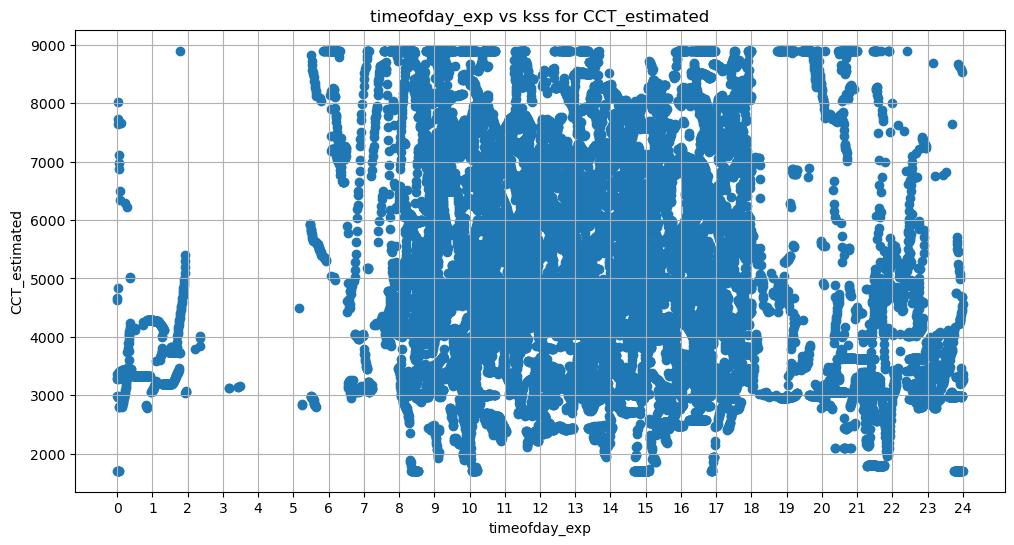

In [51]:
plt.figure(figsize=(12, 6))
plt.scatter(good_circadian['timeofday_exp'], good_circadian['CCT_estimated'])
plt.title('timeofday_exp vs kss for CCT_estimated')
plt.xlabel('timeofday_exp')
plt.ylabel('CCT_estimated')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [52]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    59 non-null     int64  
 1   age                   59 non-null     object 
 2   sex                   59 non-null     object 
 3   caffeineGeneralUnit   58 non-null     float64
 4   smokeGeneralUnit      59 non-null     object 
 5   alcoholGeneralFreq    59 non-null     object 
 6   healthSubjRate        59 non-null     object 
 7   chronotypeSubjRate    59 non-null     object 
 8   PSQItotalScore        59 non-null     int64  
 9   MCTQmsfsc             59 non-null     float64
 10  IPAQactivityCategory  59 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 5.2+ KB


In [53]:
# Keep only needed columns
baseline = baseline[['id', 'age', 'sex']]

# Merge with your main dataset (e.g., merged or kss)
good_circadian = good_circadian.merge(baseline, on='id', how='left')  # or merged = merged.merge(...)

In [54]:
good_circadian

,id,datatime_exp,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday_exp,mel_ratio,CCT_estimated,datatime_kss,timeofday_kss,timeawake,kss,time_diff,hour,day_phase,age,sex
0,1,2022-02-21 13:38:30,344.859786,530.597498,422.738084,570.215641,603.395769,750.743974,13.642,0.706762,4230.727663,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:29:40,13,day,26-30,Male
1,1,2022-02-21 13:39:00,353.819181,517.799574,494.280637,691.446072,758.734620,741.885946,13.650,0.697950,4178.276042,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:29:10,13,day,26-30,Male
2,1,2022-02-21 13:39:30,360.318543,500.174115,503.184610,704.639551,772.404470,727.843792,13.658,0.687200,4114.284576,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:28:40,13,day,26-30,Male
3,1,2022-02-21 13:40:00,360.460979,493.054753,503.461820,706.557523,774.306754,723.443052,13.667,0.681539,4080.590099,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:28:10,13,day,26-30,Male
4,1,2022-02-21 13:40:30,360.100114,482.561200,502.535329,704.943483,772.830461,714.664590,13.675,0.675228,4043.020967,2022-02-21 14:08:10,14.133,6.633000,4,0 days 00:27:40,13,day,26-30,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31066,59,2022-06-29 00:20:57,24.170873,78.012152,81.253181,52.313170,52.922300,113.943855,0.349,0.684654,4099.132830,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:23:46,0,night,18-25,Female
31067,59,2022-06-29 00:29:57,23.432972,78.530065,75.580988,50.955985,47.683533,114.023176,0.499,0.688720,4123.334570,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:14:46,0,night,18-25,Female
31068,59,2022-06-29 00:30:57,14.410925,79.026117,37.146394,36.633560,20.748596,114.060311,0.516,0.692845,4147.886948,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:13:46,0,night,18-25,Female
31069,59,2022-06-29 00:43:27,21.205208,76.808501,65.708868,55.598958,55.162881,109.503683,0.724,0.701424,4198.951816,2022-06-29 00:44:43,0.742,16.075333,8,0 days 00:01:16,0,night,18-25,Female


In [55]:
drop_cols = [
    'SconeopicEDI', 'RodopicEDI', 'MconeopicEDI', 'LconeopicEDI',
    'timeofday_exp', 'datatime_kss', 'timeofday_kss', 'time_diff', 'day_phase', 'hour'
]
df = good_circadian.drop(columns=drop_cols, errors='ignore')

In [56]:
df

,id,datatime_exp,MelanopicEDI,PhotopicLux,mel_ratio,CCT_estimated,timeawake,kss,age,sex
0,1,2022-02-21 13:38:30,530.597498,750.743974,0.706762,4230.727663,6.633000,4,26-30,Male
1,1,2022-02-21 13:39:00,517.799574,741.885946,0.697950,4178.276042,6.633000,4,26-30,Male
2,1,2022-02-21 13:39:30,500.174115,727.843792,0.687200,4114.284576,6.633000,4,26-30,Male
3,1,2022-02-21 13:40:00,493.054753,723.443052,0.681539,4080.590099,6.633000,4,26-30,Male
4,1,2022-02-21 13:40:30,482.561200,714.664590,0.675228,4043.020967,6.633000,4,26-30,Male
...,...,...,...,...,...,...,...,...,...,...
31066,59,2022-06-29 00:20:57,78.012152,113.943855,0.684654,4099.132830,16.075333,8,18-25,Female
31067,59,2022-06-29 00:29:57,78.530065,114.023176,0.688720,4123.334570,16.075333,8,18-25,Female
31068,59,2022-06-29 00:30:57,79.026117,114.060311,0.692845,4147.886948,16.075333,8,18-25,Female
31069,59,2022-06-29 00:43:27,76.808501,109.503683,0.701424,4198.951816,16.075333,8,18-25,Female


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31071 entries, 0 to 31070
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             31071 non-null  int64         
 1   datatime_exp   31071 non-null  datetime64[ns]
 2   MelanopicEDI   31071 non-null  float64       
 3   PhotopicLux    31071 non-null  float64       
 4   mel_ratio      31071 non-null  float64       
 5   CCT_estimated  31071 non-null  float64       
 6   timeawake      30902 non-null  float64       
 7   kss            31071 non-null  int64         
 8   age            31071 non-null  object        
 9   sex            31071 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 2.4+ MB


In [58]:
df['timeofday_sec'] = df['datatime_exp'].dt.hour * 3600 + df['datatime_exp'].dt.minute * 60 + df['datatime_exp'].dt.second

In [59]:
df

,id,datatime_exp,MelanopicEDI,PhotopicLux,mel_ratio,CCT_estimated,timeawake,kss,age,sex,timeofday_sec
0,1,2022-02-21 13:38:30,530.597498,750.743974,0.706762,4230.727663,6.633000,4,26-30,Male,49110
1,1,2022-02-21 13:39:00,517.799574,741.885946,0.697950,4178.276042,6.633000,4,26-30,Male,49140
2,1,2022-02-21 13:39:30,500.174115,727.843792,0.687200,4114.284576,6.633000,4,26-30,Male,49170
3,1,2022-02-21 13:40:00,493.054753,723.443052,0.681539,4080.590099,6.633000,4,26-30,Male,49200
4,1,2022-02-21 13:40:30,482.561200,714.664590,0.675228,4043.020967,6.633000,4,26-30,Male,49230
...,...,...,...,...,...,...,...,...,...,...,...
31066,59,2022-06-29 00:20:57,78.012152,113.943855,0.684654,4099.132830,16.075333,8,18-25,Female,1257
31067,59,2022-06-29 00:29:57,78.530065,114.023176,0.688720,4123.334570,16.075333,8,18-25,Female,1797
31068,59,2022-06-29 00:30:57,79.026117,114.060311,0.692845,4147.886948,16.075333,8,18-25,Female,1857
31069,59,2022-06-29 00:43:27,76.808501,109.503683,0.701424,4198.951816,16.075333,8,18-25,Female,2607


In [60]:
# Define total seconds in a day
SECONDS_IN_DAY = 86400

# Create cyclical features
df['time_sin'] = np.sin(2 * np.pi * df['timeofday_sec'] / SECONDS_IN_DAY)
df['time_cos'] = np.cos(2 * np.pi * df['timeofday_sec'] / SECONDS_IN_DAY)

In [61]:
df

,id,datatime_exp,MelanopicEDI,PhotopicLux,mel_ratio,CCT_estimated,timeawake,kss,age,sex,timeofday_sec,time_sin,time_cos
0,1,2022-02-21 13:38:30,530.597498,750.743974,0.706762,4230.727663,6.633000,4,26-30,Male,49110,-0.416677,-0.909054
1,1,2022-02-21 13:39:00,517.799574,741.885946,0.697950,4178.276042,6.633000,4,26-30,Male,49140,-0.418660,-0.908143
2,1,2022-02-21 13:39:30,500.174115,727.843792,0.687200,4114.284576,6.633000,4,26-30,Male,49170,-0.420640,-0.907228
3,1,2022-02-21 13:40:00,493.054753,723.443052,0.681539,4080.590099,6.633000,4,26-30,Male,49200,-0.422618,-0.906308
4,1,2022-02-21 13:40:30,482.561200,714.664590,0.675228,4043.020967,6.633000,4,26-30,Male,49230,-0.424595,-0.905384
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31066,59,2022-06-29 00:20:57,78.012152,113.943855,0.684654,4099.132830,16.075333,8,18-25,Female,1257,0.091284,0.995825
31067,59,2022-06-29 00:29:57,78.530065,114.023176,0.688720,4123.334570,16.075333,8,18-25,Female,1797,0.130310,0.991473
31068,59,2022-06-29 00:30:57,79.026117,114.060311,0.692845,4147.886948,16.075333,8,18-25,Female,1857,0.134635,0.990895
31069,59,2022-06-29 00:43:27,76.808501,109.503683,0.701424,4198.951816,16.075333,8,18-25,Female,2607,0.188453,0.982082


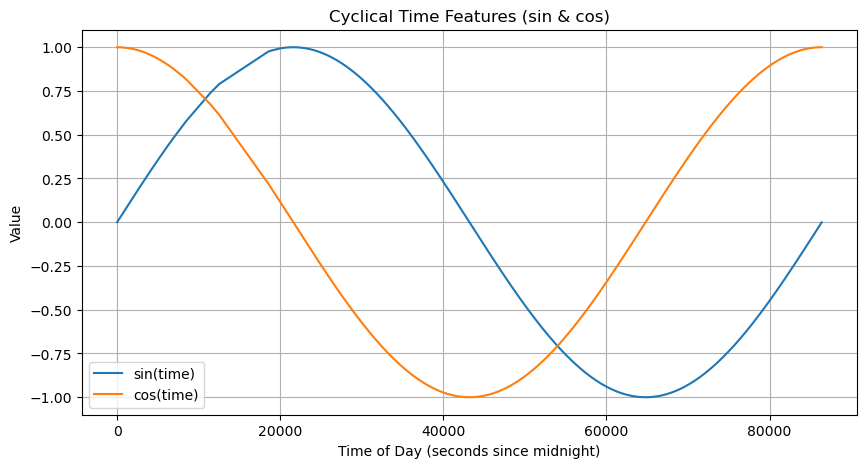

In [62]:
df_sorted = df.sort_values('timeofday_sec')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_sorted['timeofday_sec'], df_sorted['time_sin'], label='sin(time)')
plt.plot(df_sorted['timeofday_sec'], df_sorted['time_cos'], label='cos(time)')
plt.xlabel('Time of Day (seconds since midnight)')
plt.ylabel('Value')
plt.title('Cyclical Time Features (sin & cos)')
plt.legend()
plt.grid(True)
plt.show()

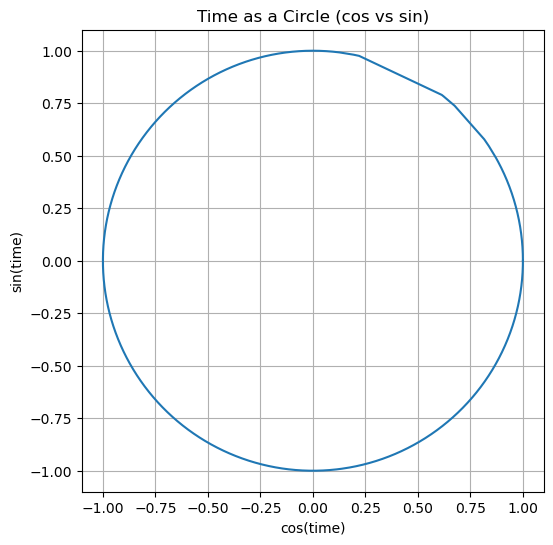

In [63]:
plt.figure(figsize=(6, 6))
plt.plot(df_sorted['time_cos'], df_sorted['time_sin'], label='Time circle')
plt.xlabel('cos(time)')
plt.ylabel('sin(time)')
plt.title('Time as a Circle (cos vs sin)')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31071 entries, 0 to 31070
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             31071 non-null  int64         
 1   datatime_exp   31071 non-null  datetime64[ns]
 2   MelanopicEDI   31071 non-null  float64       
 3   PhotopicLux    31071 non-null  float64       
 4   mel_ratio      31071 non-null  float64       
 5   CCT_estimated  31071 non-null  float64       
 6   timeawake      30902 non-null  float64       
 7   kss            31071 non-null  int64         
 8   age            31071 non-null  object        
 9   sex            31071 non-null  object        
 10  timeofday_sec  31071 non-null  int32         
 11  time_sin       31071 non-null  float64       
 12  time_cos       31071 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(1), int64(2), object(2)
memory usage: 3.0+ MB


In [65]:
def parse_age(val):
    if isinstance(val, str) and '-' in val:
        a, b = val.split('-')
        return (int(a) + int(b)) / 2
    try:
        return float(val)
    except:
        return np.nan

df['age_numeric'] = df['age'].apply(parse_age)

In [66]:
df

,id,datatime_exp,MelanopicEDI,PhotopicLux,mel_ratio,CCT_estimated,timeawake,kss,age,sex,timeofday_sec,time_sin,time_cos,age_numeric
0,1,2022-02-21 13:38:30,530.597498,750.743974,0.706762,4230.727663,6.633000,4,26-30,Male,49110,-0.416677,-0.909054,28.0
1,1,2022-02-21 13:39:00,517.799574,741.885946,0.697950,4178.276042,6.633000,4,26-30,Male,49140,-0.418660,-0.908143,28.0
2,1,2022-02-21 13:39:30,500.174115,727.843792,0.687200,4114.284576,6.633000,4,26-30,Male,49170,-0.420640,-0.907228,28.0
3,1,2022-02-21 13:40:00,493.054753,723.443052,0.681539,4080.590099,6.633000,4,26-30,Male,49200,-0.422618,-0.906308,28.0
4,1,2022-02-21 13:40:30,482.561200,714.664590,0.675228,4043.020967,6.633000,4,26-30,Male,49230,-0.424595,-0.905384,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31066,59,2022-06-29 00:20:57,78.012152,113.943855,0.684654,4099.132830,16.075333,8,18-25,Female,1257,0.091284,0.995825,21.5
31067,59,2022-06-29 00:29:57,78.530065,114.023176,0.688720,4123.334570,16.075333,8,18-25,Female,1797,0.130310,0.991473,21.5
31068,59,2022-06-29 00:30:57,79.026117,114.060311,0.692845,4147.886948,16.075333,8,18-25,Female,1857,0.134635,0.990895,21.5
31069,59,2022-06-29 00:43:27,76.808501,109.503683,0.701424,4198.951816,16.075333,8,18-25,Female,2607,0.188453,0.982082,21.5


In [67]:
df['sex_encoded'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

In [68]:
df['log_lux'] = np.log1p(df['PhotopicLux'])

In [69]:
df

,id,datatime_exp,MelanopicEDI,PhotopicLux,mel_ratio,CCT_estimated,timeawake,kss,age,sex,timeofday_sec,time_sin,time_cos,age_numeric,sex_encoded,log_lux
0,1,2022-02-21 13:38:30,530.597498,750.743974,0.706762,4230.727663,6.633000,4,26-30,Male,49110,-0.416677,-0.909054,28.0,1,6.622396
1,1,2022-02-21 13:39:00,517.799574,741.885946,0.697950,4178.276042,6.633000,4,26-30,Male,49140,-0.418660,-0.908143,28.0,1,6.610543
2,1,2022-02-21 13:39:30,500.174115,727.843792,0.687200,4114.284576,6.633000,4,26-30,Male,49170,-0.420640,-0.907228,28.0,1,6.591459
3,1,2022-02-21 13:40:00,493.054753,723.443052,0.681539,4080.590099,6.633000,4,26-30,Male,49200,-0.422618,-0.906308,28.0,1,6.585403
4,1,2022-02-21 13:40:30,482.561200,714.664590,0.675228,4043.020967,6.633000,4,26-30,Male,49230,-0.424595,-0.905384,28.0,1,6.573212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31066,59,2022-06-29 00:20:57,78.012152,113.943855,0.684654,4099.132830,16.075333,8,18-25,Female,1257,0.091284,0.995825,21.5,0,4.744444
31067,59,2022-06-29 00:29:57,78.530065,114.023176,0.688720,4123.334570,16.075333,8,18-25,Female,1797,0.130310,0.991473,21.5,0,4.745134
31068,59,2022-06-29 00:30:57,79.026117,114.060311,0.692845,4147.886948,16.075333,8,18-25,Female,1857,0.134635,0.990895,21.5,0,4.745456
31069,59,2022-06-29 00:43:27,76.808501,109.503683,0.701424,4198.951816,16.075333,8,18-25,Female,2607,0.188453,0.982082,21.5,0,4.705049


In [70]:
timeawake_min = df['timeawake'].min()
timeawake_max = df['timeawake'].max()

print(f"Minimum timeawake_min: {timeawake_min:.3f}")
print(f"Maximum timeawake_max: {timeawake_max:.3f}")

Minimum timeawake_min: 0.000
Maximum timeawake_max: 23.942


In [71]:
# Select features and targets
X = df[['age_numeric', 'timeawake', 'sex_encoded', 'time_sin', 'time_cos']]
y = df[['mel_ratio', 'log_lux']]

# Scale the outputs
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [72]:
# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [73]:
# Predict (scaled)
y_pred_scaled = model.predict(X_test)

# Unscale predictions and targets for evaluation
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Evaluate
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

MAE: 0.015994373173998586
R² Score: 0.9935285480834448


In [74]:
# Separate predictions
mel_pred = y_pred[:, 0]
lux_pred = y_pred[:, 1]
mel_true = y_true[:, 0]
lux_true = y_true[:, 1]

# Evaluate mel_ratio
print("mel_ratio MAE:", mean_absolute_error(mel_true, mel_pred))
print("mel_ratio R² Score:", r2_score(mel_true, mel_pred))

# Evaluate PhotopicLux
print("PhotopicLux MAE:", mean_absolute_error(lux_true, lux_pred))
print("PhotopicLux R² Score:", r2_score(lux_true, lux_pred))

mel_ratio MAE: 0.005479003843783578
mel_ratio R² Score: 0.9913080499828668
PhotopicLux MAE: 0.026509742504213517
PhotopicLux R² Score: 0.9957490461840229


In [75]:
# Save model
joblib.dump(model, 'models/lighting_model2.pkl')

# Save scaler
joblib.dump(scaler_y, 'models/lscaler_y2.pkl')

['models/lscaler_y2.pkl']

In [76]:
# 5. Predict scaled output
y_pred_scaled = model.predict(X)
print(f"Scaled Prediction: {y_pred_scaled}")

# 6. Inverse scale to get true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
print(f"Inverse Scaled Prediction: {y_pred}")

Scaled Prediction: [[0.4447451  0.47198395]
 [0.44105782 0.47113984]
 [0.43086235 0.46839121]
 ...
 [0.42833541 0.13008312]
 [0.4212054  0.1271834 ]
 [0.4212054  0.1271834 ]]
Inverse Scaled Prediction: [[0.70027059 6.61291287]
 [0.69695204 6.60831026]
 [0.68777612 6.59332315]
 ...
 [0.68550187 4.74867168]
 [0.67908486 4.7328607 ]
 [0.67908486 4.7328607 ]]


In [77]:
print(f"Scaler y_min: {scaler_y.data_min_}")
print(f"Scaler y_max: {scaler_y.data_max_}")

Scaler y_min: [0.3        4.03938321]
Scaler y_max: [1.2        9.49196196]


In [79]:
sleep.head()

,id,datatime,workdayYesterday,caffeineYesterdayUnit,smokeYesterdayUnit,alcoholYesterdayUnit,napYesterday,sleepQualitySubjRateYesterday,gobedTimeYesterday,wakeTimeToday,sleepDurationYesterday,sleepOnsetLatencyYesterday
0,1,21/02/2022 12:43,Free,2.0,Never,0.0,No,VeryGood,-1.00,7.5,8.0,0.250000
1,1,22/02/2022 07:52,Work,4.0,Never,0.0,No,Good,1.00,7.5,6.0,0.500000
2,1,23/02/2022 08:31,Work,4.0,Never,0.0,No,Good,1.50,8.5,7.0,0.083333
3,1,24/02/2022 09:02,Work,3.0,Never,0.0,No,VeryGood,2.00,9.0,7.0,0.083333
4,1,25/02/2022 08:02,Work,3.0,Never,0.0,No,VeryGood,-0.25,8.0,8.0,0.083333
